In [1]:
!git clone https://github.com/autonlab/auton-survival
#edit "random_seed=123" at auton-survival>auton-survival>models>dsm>__init_.py__

Cloning into 'auton-survival'...
remote: Enumerating objects: 1673, done.
remote: Counting objects: 100% (1061/1061), done.
remote: Compressing objects: 100% (744/744), done.
remote: Total 1673 (delta 684), reused 571 (delta 301), pack-reused 612
Receiving objects: 100% (1673/1673), 28.96 MiB | 18.74 MiB/s, done.
Resolving deltas: 100% (1060/1060), done.


In [2]:
!pip install scikit-survival

     |████████████████████████████████| 2.5 MB 10.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.17.1-cp37-cp37m-linux_x86_64.whl size=4088345 sha256=40538611078369b4ad1f8dc5aaa01117698173fcbdeae98750bc92ecad8900cf
  Stored in directory: /root/.cache/pip/wheels/78/43/46/b5c9ba2d44e7e5de3d321c76bbff4e5480cd69d486b38d359f
Successfully built scikit-survival


In [3]:
import sys
sys.path.insert(0,'/content/auton-survival')

from google.colab import drive
drive.mount('/content/drive')
#d_master_3hourlyCleaned_v1.csv'

Mounted at /content/drive


In [4]:
from auton_survival.models.dsm import DeepRecurrentSurvivalMachines
#from auton_survival import datasets

import io
import pkgutil
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import torchvision

In [5]:
def increase_censoring(e, t, p, random_seed=123):

  np.random.seed(random_seed)

  uncens = np.where(e == 1)[0]
  mask = np.random.choice([False, True], len(uncens), p=[1-p, p])
  toswitch = uncens[mask]

  e[toswitch] = 0
  t_ = t[toswitch]

  newt = []
  for t__ in t_:
    newt.append(np.random.uniform(1, t__))
  t[toswitch] = newt

  return e, t


In [6]:
data = pd.read_csv("/content/drive/MyDrive/SPH6004_Assignment2/d_master_3hourlyCleaned_v1.csv")
dat_num1 = data[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 
                   'cerebrovascular_disease','dementia', 'chronic_pulmonary_disease', 'rheumatic_disease', 
                   'peptic_ulcer_disease', 'mild_liver_disease', 'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia', 
                   'renal_disease', 'malignant_cancer', 'severe_liver_disease', 'metastatic_solid_tumor', 'aids','Med_Aminoglycosides', 
                   'Med_Angiotensin', 'Med_Diuretics', 'Med_NSAID', 'Med_Vancomycin', 'Procedure_Ventilation','Procedure_Intubation_Extubation']]

dat_num = data[['adm_age', 'so2', 'po2', 'pco2', 'fio2_chartevents', 'aado2_calc', 'pao2fio2ratio', 'ph', 
                  'baseexcess', 'totalco2', 'hematocrit', 'hemoglobin', 'chloride', 'calcium', 'potassium','sodium', 
                  'lactate', 'glucose', 'heart_rate_avg', 'sbp_avg', 'dbp_avg', 'sbp_ni_avg', 'dbp_ni_avg', 'mbp_ni_avg', 'tmp_avg', 'spo2_avg', 'glucose_avg']]

x1 = dat_num1.values
x2 = dat_num.values
x = np.hstack([x1, x2])

time = (data['maxStay'] - data['t_ICU2Chart']).values + 3
event = data['AKI'].values

x = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(x)


x_ = StandardScaler().fit_transform(x)

x, t, e = [], [], []
for id_ in sorted(list(set(data['stay_id']))):
      x.append(x_[data['stay_id'] == id_])
      t.append(time[data['stay_id'] == id_])
      e.append(event[data['stay_id'] == id_])



In [7]:
import numpy as np
horizons = [0.25, 0.5, 0.75]
times = np.quantile([t_[-1] for t_, e_ in zip(t, e) if e_[-1] == 1], horizons).tolist()

n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = np.array(x[:tr_size], dtype = object), np.array(x[-te_size:], dtype = object), np.array(x[tr_size:tr_size+vl_size], dtype = object)
t_train, t_test, t_val = np.array(t[:tr_size], dtype = object), np.array(t[-te_size:], dtype = object), np.array(t[tr_size:tr_size+vl_size], dtype = object)
e_train, e_test, e_val = np.array(e[:tr_size], dtype = object), np.array(e[-te_size:], dtype = object), np.array(e[tr_size:tr_size+vl_size], dtype = object)

from sklearn.model_selection import ParameterGrid

param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [1e-5, 1e-4, 1e-3],
              'hidden': [50, 100, 120],
              'layers': [7, 5, 3, 2, 1],
              'typ': ['LSTM', 'GRU', 'RNN'],
             }
params = ParameterGrid(param_grid)

from auton_survival.models.dsm import DeepRecurrentSurvivalMachines


In [8]:
models = []
for param in params:
    model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'], random_seed=123
                                )
    model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(x_val, t_val, e_val), model]])

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


In [9]:
best_model = min(models)
model = best_model[0][1]

In [10]:
print("best model parameters")
print("Nbrs of layers:", model.layers)
print("hidden layers:", model.hidden)
print("type:", model.typ)
# print("learning rate ", model.learning_rate)
# print("distribution:", model.distribution)

best model parameters
Nbrs of layers: 5
hidden layers: 100
type: RNN


In [11]:
out_risk = model.predict_risk(x_test, times)
out_survival = model.predict_survival(x_test, times)

In [12]:
print(out_risk)
print(out_survival)

[[0.00694645 0.0146838  0.02764516]
 [0.0143869  0.02652727 0.04456769]
 [0.01750272 0.03123775 0.05106028]
 ...
 [0.02890037 0.06536062 0.12461547]
 [0.00748982 0.01659241 0.03231731]
 [0.00985602 0.02039845 0.03759547]]
[[0.99305355 0.9853162  0.97235484]
 [0.9856131  0.97347273 0.95543231]
 [0.98249728 0.96876225 0.94893972]
 ...
 [0.97109963 0.93463938 0.87538453]
 [0.99251018 0.98340759 0.96768269]
 [0.99014398 0.97960155 0.96240453]]


In [13]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
cis = []
brs = []

et_train = np.array([(e_train[i][j], t_train[i][j]) for i in range(len(e_train)) for j in range(len(e_train[i]))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i][j], t_test[i][j]) for i in range(len(e_test)) for j in range(len(e_test[i]))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i][j], t_val[i][j]) for i in range(len(e_val)) for j in range(len(e_val[i]))],
                 dtype = [('e', bool), ('t', float)])



In [ ]:
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_train, out_risk[:, i], times[i])[0])
    brs.append(brier_score(et_train, et_train, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_train, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

In [14]:
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
    brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.6965255594623507
Brier Score: 0.020877161967448096
ROC AUC  0.6978214241203047 

For 0.5 quantile,
TD Concordance Index: 0.6941434698893775
Brier Score: 0.04196986931708036
ROC AUC  0.6973906448383178 

For 0.75 quantile,
TD Concordance Index: 0.6958245979192792
Brier Score: 0.06780270874368269
ROC AUC  0.7051383695191079 



In [15]:
#Saving the test results 
et_test1 = [row[0] for row in et_test]
et_test1_df = pd.DataFrame(et_test1)
et_test1_df.columns = ["y_test"]

out_risk_df = pd.DataFrame(out_risk)
out_risk_df.columns = ["p25","p50", 'p75']

out_risk_df1=pd.concat([out_risk_df, et_test1_df], axis=1)

#Saving the test results 
from google.colab import files
#out_risk_df1.to_csv('out_risk.csv') 
#files.download('out_risk.csv')

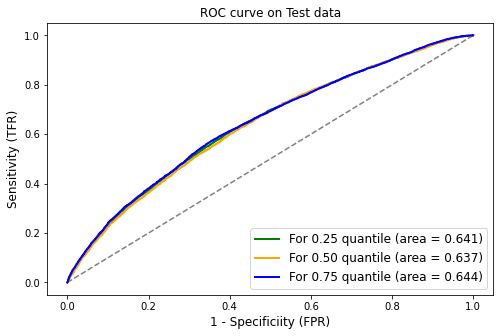

In [16]:
def plotROCcurve1 (et_test, out_risk):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc

    #ROC curve for test
    fpr_test1, tpr_test1, thresholds_test = roc_curve(et_test, out_risk[:, 0])
    auc_testdata1 = auc(fpr_test1, tpr_test1)

    fpr_test2, tpr_test2, thresholds_test = roc_curve(et_test, out_risk[:, 1])
    auc_testdata2 = auc(fpr_test2, tpr_test2)
    
    fpr_test3, tpr_test3, thresholds_test = roc_curve(et_test, out_risk[:, 2])
    auc_testdata3 = auc(fpr_test3, tpr_test3)

    #Plot ROC curve
    plt.figure(figsize=(8, 5))
    plt.plot([0, 1], [0,1], 'k--', color='grey')
    plt.plot(fpr_test2, tpr_test2, label='For 0.25 quantile (area = {:.3f})'.format(auc_testdata2), color='green', linewidth=2.0)
    plt.plot(fpr_test3, tpr_test3, label='For 0.50 quantile (area = {:.3f})'.format(auc_testdata3), color='orange',linewidth=2.0)
    plt.plot(fpr_test1, tpr_test1, label='For 0.75 quantile (area = {:.3f})'.format(auc_testdata1), color='blue', linewidth=2.0)
    plt.xlabel('1 - Specificiity (FPR)', fontsize='large')
    plt.ylabel('Sensitivity (TFR)', fontsize='large')
    plt.title('ROC curve on Test data', fontsize='large')
    plt.legend(loc=4, fontsize='large')
    #plt.savefig("ROC.png", bbox_inches='tight', format='png', dpi=300)
    plt.show()
    
plotROCcurve1 (et_test1, out_risk)